**Recreating the the embedded plasmid figure (frankenplasmid)**


The embedded plasmid test was done by embedding a database of plasmids into one single genome, creating a large "frankenplasmid". This allowed us to test how well our methods are able to find mobile genetic elements that may be embedded within a genome.

1. First, create your frankenplasmid. Lets assume our chunk size when running skadiver is 10kbp. Then we take a very large genome, and insert a plasmid every 10 kbp as such: base genome (1-9999) + plasmid_1 + base_genome(10,000-19,999) etc... until all plasmids have been inserted. This was created using the following command:

```
python3 create_giant_plasmid.py <plasmids.fasta> <base_genome.fasta> <chunk_size>
```
This outputs a .fasta file of your frankenplasmid, with 10kbp (or desired chunk size) between each plasmid
Keep in mind the size of your base genome must be >= chunk_size*(number of plasmids + 2)


This will also output a .csv of the locations of each plasmid.

2. Run Skandiver on the franken plasmid using the chunk size you chose. Then, extract the data from the skandiver output using the following command:

```
python3 franken_plasmid_analysis.py <skani_output> <.csv file of locations and names> <output file of found plasmids>
```
This will output a list of the names of the plasmids that were found by skandiver
3. Run genomad on the frankenplasmid. Genomad had a very difficult time intaking such a large genome, so I suggest chunking the franken plasmid into smaller pieces first (I chose 5 million bp) using the following command:

```
python3 chunktwentytwo.py <franken_plasmid.fasta> <chunked_5m_franken_plasmid.fasta output file> 5000000
```
Then, added indexes to the gene id's to make genomad happy. Use the following command:

```
python3 add_indexes_to_multifasta.py <chunked_5m_franken_plasmid.fasta>
```
4. Analyse the genomad output using the following commands (there are different ones for virus and plasmid output files)

```
python3 analyze_genomad_frankenvirus.py <genomad_output_virus_summary.tsv> <plasmid_locations(from earlier).csv> <genomad_output_of_found_viruses.txt>

```
```
python3 analyze_genomad_franken_plasmid.py <genomad_output_plasmid_genes.tsv> <plasmid_locations(from earlier).csv> <genomad_output_of_found_plasmids.txt>

```
Then combine the two files in union of the plasmid names

```
python3 combine_files.py <genomad_found_plasmids.txt> <genomad_found_viruses.txt> <genomad_all_MGE_found.txt>

```
5. Run Mefinder on the franken plasmid. It took a while to run, but no need to chunk the franken plasmid into smaller pieces. Use the following commad to extract the found plasmids:

```
python3 analyze_mefinder_franken_plasmid.py <mefinder_franken_plasmid_output.csv> <plasmid_locations.csv> <mefinder_found_plasmids.txt>

```
6. Now that all data has been collected from each method, we can graph the results. You will need a .csv file with the plasmid name and its length. Use the following code block / function below to plot the data:

In [ ]:
# if you don't have the data for one of the methods, just say None in its place
plot_hist(<plasmid_lengths>, <skandiver>, <genomad>, <mefinder>, <bucket_num(number of buckets you want in the histogram>)

In [ ]:
#@title Graph Plotting Function
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches

def make_percentages(og_bucket_count, new_bucket):
    percentages = []
    for i in range(len(og_bucket_count)):
        per = (new_bucket[i]/og_bucket_count[i])*100
        #print("per", per)
        percentages.append(per)
    return percentages

def obtain_bucket_counts(plasmid_lengths_df, bin_edges, found_plasmids, num_buckets):
    found_bucket_counts = {i: 0 for i in range(num_buckets)}
    for length in plasmid_lengths_df[plasmid_lengths_df["Gene Name"].isin(found_plasmids)]["Length"]:
        bucket_index = find_index(length, bin_edges)
        #print(length)
        found_bucket_counts[bucket_index] += 1
    return found_bucket_counts

def find_index(length, bin_edges):
    for i in range(0, len(bin_edges)-1):
        if bin_edges[i] <= length and length <= bin_edges[i+1]:
            #print(f'{bin_edges[i]} <={length} <= {bin_edges[i+1]}', i)
            return i
    return len(bin_edges)-2

def plot_hist(plasmid_lengths, skandiver, genomad, mefinder, bucket_num):
    # Sample data for four different sets of bars
    skani_color =  (254/255, 17/255, 17/255)
    genomad_color =  (1/255, 207/255, 13/255)
    mefinder_color =  (1/255, 40/255, 218/255)

    bucket_arr = []
    for i in range(1, bucket_num+1):
        bucket_arr.append(i)
    x = np.array(bucket_arr)

    plasmid_lengths_df = pd.read_csv(plasmid_lengths)

    min_length = min(plasmid_lengths_df["Length"])
    max_length = max(plasmid_lengths_df["Length"])
    # Specify the number of buckets and bucket size
    num_buckets = bucket_num
    bin_edges = np.logspace(np.log10(min_length), np.log10(max_length), num=num_buckets+1)
    bucket_size = max(plasmid_lengths_df["Length"]) // num_buckets

    bucket_counts_original = {i: 0 for i in range(num_buckets)}
    for length in plasmid_lengths_df["Length"]:
        bucket_index = find_index(length, bin_edges)
        bucket_counts_original[bucket_index] += 1

    # Width of each bar
    width = 0.2

    genomad_color =  (1/255, 207/255, 13/255)

    if skandiver:
        with open(skandiver, "r") as file:  # Replace with the path to your found plasmids file
            found_skani_plasmids = [line.strip() for line in file]
        skandiver_count = obtain_bucket_counts(plasmid_lengths_df, bin_edges, found_skani_plasmids, bucket_num)
        skandiver_plot = make_percentages(bucket_counts_original, skandiver_count)
        y3 = np.array(skandiver_plot)
        plt.bar(x + 3 * width, y3, width=width, color='red', label='')

    if mefinder:
            with open(mefinder, "r") as file:  # Replace with the path to your found plasmids file
                found_mefinder_plasmids = [line.strip() for line in file]
            mefinder_count = obtain_bucket_counts(plasmid_lengths_df, bin_edges, found_mefinder_plasmids, bucket_num)
            mefinder_plot = make_percentages(bucket_counts_original, mefinder_count)
            y2 = np.array(mefinder_plot)
            # Plotting the second set of bars with a specific color
            plt.bar(x + width, y2, width=width, color='blue')

    if genomad:
            with open(genomad, "r") as file:  # Replace with the path to your found plasmids file
                found_genomad_plasmids = [line.strip() for line in file]
            genomad_count = obtain_bucket_counts(plasmid_lengths_df, bin_edges, found_genomad_plasmids, bucket_num)
            genomad_plot = make_percentages(bucket_counts_original, genomad_count)
            y4 = np.array(genomad_plot)
            # Plotting the fourth set of bars with a specific color
            plt.bar(x + 2*width, y4, width=width, color=(1/255, 207/255, 13/255))

    #print("mefinder", mefinder_plot)
    #print("genomad", genomad_plot)
    #print("skandiver", skandiver_plot)
    bucket_labels = []
    for i in range(bucket_num):
        bucket_labels.append(f"{bin_edges[i]}-{bin_edges[i+1]}")
    print("bin edges ", bucket_labels)
    # Labeling the x-axis
    plt.xlabel('Bin edges')

    # Labeling the y-axis
    plt.ylabel('Percent Plasmids Found')

    # Adding a title
    plt.title('Percent of Plasmids Found For each Method')

    plt.legend(handles=[patches.Patch(color=skani_color, label='skandiver'),
                    patches.Patch(color=mefinder_color, label='mefinder'),
                    patches.Patch(color=genomad_color, label='genomad')],
            bbox_to_anchor=(1.05, 1), loc='upper left')


    # Display the plot
    plt.show()

bin edges  ['829.9999999999997-2846.089433710037', '2846.089433710037-9759.307306838462', '9759.307306838462-33464.89326062906', '33464.89326062906-114751.90254133813', '114751.90254133813-393486.9606277428', '393486.9606277428-1349276.0011389144', '1349276.0011389144-4626698.999999998']


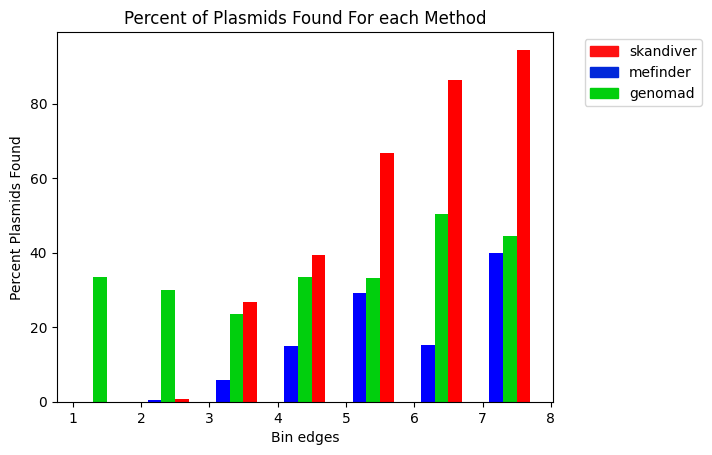

In [ ]:
#@title practice:
plot_hist("plasmid_lengths.csv", "true_found_10k_franken_plasmids.txt", "genomad_all_MGE_found.txt", "mefinder_found_10k_franken_plasmids.txt", 7)